# Preprocessing the time series data for Hierarchical classification
This script is used for extracting the typical time series data for later multimodal classification, mainly considering the 48 hours, 72 hours and 96 hours after admission
- 1 - Precondition: The established empty table P1_SIGN_48H, P1_SIGN_72H and P1_SIGN_96H in oracle db

In [1]:
from __future__ import print_function

import os
import re
import sys
import math
import pickle
import datetime
import itertools
import traceback
import numpy as np
import pandas as pd
from copy import deepcopy
import matplotlib.pyplot as plt
from collections import OrderedDict
from collections import Counter
# from tqdm import tqdm_notebook as tqdm
from tqdm.notebook import tqdm
from sklearn import preprocessing
from sklearn.impute import SimpleImputer
from multiprocessing import Pool, cpu_count
from sklearn.model_selection import KFold,StratifiedKFold
from operator import itemgetter, attrgetter, methodcaller
from sqlalchemy import Table, select, text, distinct, types
from sqlalchemy.dialects.oracle import BFILE, BLOB, CHAR, CLOB, DATE, DOUBLE_PRECISION, FLOAT, INTERVAL, LONG, NCLOB, NUMBER, NVARCHAR, NVARCHAR2, RAW, TIMESTAMP, VARCHAR, VARCHAR2

from utils.utils import sparsify
from config.orcl import db_connection

%matplotlib inline

### 1-process SIGNS table into P1_SIGN_48H, P1_SIGN_72H, P1_SIGN_96H

In [2]:
# connect to the database
try:
    db_conn = db_connection('fuo')
    db_conn.conn.close()
    print('[info] Connected to oracle database!')
except:
    print('[info] Failed to connect!')

# define the basic param
TS_TYPE = ['体温', '呼吸', '脉搏', '血压', 'SPO2']
T_LENGTH = 120 # 48, 72, 96

[info] Connected to oracle database!


In [3]:
def mapping_df_types(df, table_name):
    """
    INPUT: df(要插回数据库的DataFrame数据)
    OUTPUT: dtypedict(指定每个字段要插入到数据库的字段类型)
    """
    #定义空字典
    dtypedict = {}
    if table_name.lower() in ['p1_sign_48h', 'p1_sign_72h', 'p1_sign_96h', 'p1_sign_120h']:
        for i, j in zip(df.columns, df.dtypes):
            if str(i) == "sign_id":
                dtypedict.update({i: VARCHAR2(100)})
            if str(i) == "visit_record_id":
                dtypedict.update({i: VARCHAR2(50)})
            if str(i) =="visit_record_id_new_1":
                dtypedict.update({i: VARCHAR2(50)})
            if str(i) == "person_id":
                dtypedict.update({i: VARCHAR2(100)})
            if str(i) == "mea_time":
                dtypedict.update({i: VARCHAR2(100)})
            if str(i) == "type":
                dtypedict.update({i: VARCHAR2(20)})
            if str(i) == "value":
                dtypedict.update({i: VARCHAR2(100)})
            if str(i) == "unit":
                dtypedict.update({i: VARCHAR2(20)})

    return dtypedict

def data_insert(data, db_conn, dtypedict_status=True):
    """
    INPUT: data(要插回数据库的数据)
    """
    # table name
    table_name = 'p1_sign_{}h'.format(T_LENGTH)
    # get the dict
    if dtypedict_status:
        dtypedict = mapping_df_types(data, table_name)
    else:
        dtypedict = None
    # insert data into db
    data.to_sql(table_name, db_conn.engine, index=False, if_exists='append', dtype=dtypedict, chunksize=10)

In [4]:
def extract_signs(vri):

    db_conn = db_connection('fuo')
    sql = '''
                select sign_id,
                       visit_record_id,
                       visit_record_id_new_1,
                       person_id,
                       mea_time,
                       type,
                       value,
                       high_value,
                       unit
                from signs where visit_record_id_new_1='{0}'
        '''.format(vri)
    result = db_conn.conn.execute(sql).fetchall()
    df_sign = pd.DataFrame(result, columns=['sign_id', 'visit_record_id','visit_record_id_new_1','person_id','mea_time','type', 'value', 'high_value', 'unit'])

    df_sign = df_sign[df_sign['type'].isin(TS_TYPE)]

    if any(df_sign.duplicated(subset=['visit_record_id_new_1', 'type', 'mea_time', 'value', 'high_value'])):
        df_sign.sort_values(by = ['visit_record_id_new_1', 'type', 'mea_time'], na_position = 'last', inplace = True, ascending=True)
        df_sign.drop_duplicates(subset=['visit_record_id_new_1', 'type', 'mea_time', 'value', 'high_value'], keep='first', inplace=True)

    # process the unusual data
    df_sign.loc[df_sign['value'] == '.', ['value']] = None
    df_sign['value'] = df_sign['value'].replace('\.{2,100}', '.', regex=True)
    df_sign['value'] = df_sign['value'].replace('^\.(?=\d+)', '', regex=True)

    #extract the admission time and keep the data in Xhours time range
    sql = '''
            select visit_record_id_new_1, 
                   visit_start_date
            from visit_zy 
            where visit_record_id_new_1='{0}'
            '''.format(vri)
    result = db_conn.conn.execute(sql).fetchall()
    data_visit = pd.DataFrame(result, columns=['visit_record_id_new_1', 'visit_start_date'])
    max_date = data_visit['visit_start_date'].min() + np.timedelta64(T_LENGTH, 'h')
    data = df_sign.loc[df_sign['mea_time'] <= max_date,]
    data['mea_time'] = data['mea_time'].astype(str)

    # split the diastolic pressure and systolic pressure
    data_diag = data[['sign_id', 'visit_record_id','visit_record_id_new_1','person_id','mea_time','type', 'value', 'unit']]
    data_diag.loc[data_diag['type'] == '血压', ['type']] = '舒张压'

    data_syst = data.loc[data['type'] == '血压', ]
    data_syst = data_syst[['sign_id', 'visit_record_id','visit_record_id_new_1','person_id','mea_time','type', 'high_value', 'unit']]
    data_syst.rename(columns={'high_value': 'value'}, inplace=True)
    data_syst.loc[data_syst['type'] == '血压', ['type']] = '收缩压'

    data_all = pd.concat([data_diag, data_syst], axis=0)

    data_insert(data_all, db_conn, dtypedict_status=True)

    db_conn.conn.close()


In [5]:
# get the visit_record_id list
sql = '''
select distinct visit_record_id_new_1
from signs
'''
db_conn = db_connection('fuo')
vris_db = db_conn.conn.execute(sql).fetchall()
vris = [x for (x,) in vris_db]
db_conn.conn.close()

def process_visit_list(vid_list):
    for vid in tqdm(vid_list):
        extract_signs(vid)

num_workers = 4
p = Pool(num_workers)
for vid_list in np.array_split(vris, num_workers):
    p.apply_async(process_visit_list, args=(vid_list,))
p.close()
p.join()


/home/zju/anaconda3/envs/gru/lib/python3.6/site-packages/ipykernel_launcher.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/zju/anaconda3/envs/gru/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/home/zju/anaconda3/envs/gru/lib/python3.6/site-packages/ipykernel_launcher.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

### 2-extract the statistics data from P1_SIGN_48H, P1_SIGN_72H, P1_SIGN_96H

In [6]:
# define the basic param
TS_TYPE = ['体温', '呼吸', '脉搏', '舒张压', '收缩压', 'SPO2']
T_LENGTH = 120 # 48, 72, 96

In [7]:
def mapping_df_types(df, table_name):
    """
    INPUT: df(要插回数据库的DataFrame数据)
    OUTPUT: dtypedict(指定每个字段要插入到数据库的字段类型)
    """
    #定义空字典
    dtypedict = {}
    if table_name.lower() in ['p1_sign_stat_48h', 'p1_sign_stat_72h', 'p1_sign_stat_96h', 'p1_sign_stat_120h']:
        for i, j in zip(df.columns, df.dtypes):
            if str(i) =="visit_record_id_new_1":
                dtypedict.update({i: VARCHAR2(50)})
            if str(i) == "type":
                dtypedict.update({i: VARCHAR2(20)})
            if str(i) == "min_value":
                dtypedict.update({i: VARCHAR2(20)})
            if str(i) == "max_value":
                dtypedict.update({i: VARCHAR2(20)})
            if str(i) == "avg_value":
                dtypedict.update({i: VARCHAR2(20)})
            if str(i) == "std_value":
                dtypedict.update({i: VARCHAR2(20)})
            if str(i) == "median_value":
                dtypedict.update({i: VARCHAR2(20)})

    return dtypedict

def data_insert(data, db_conn, dtypedict_status=True):
    """
    INPUT: data(要插回数据库的数据)
    """
    # table name
    table_name = 'p1_sign_stat_{}h'.format(T_LENGTH)
    # get the dict
    if dtypedict_status:
        dtypedict = mapping_df_types(data, table_name)
    else:
        dtypedict = None
    # insert data into db
    data.to_sql(table_name, db_conn.engine, index=False, if_exists='append', dtype=dtypedict, chunksize=10)

In [8]:
def extract_statistics(vri):
    
    db_conn = db_connection('fuo')
    data_out = pd.DataFrame([], columns=['visit_record_id_new_1','type','min_value','max_value','avg_value', 'std_value','median_value'])
    
    for j in TS_TYPE:
        sql = '''
            select visit_record_id_new_1,
                    type,
                    value
            from p1_sign_{0}h
            where type='{1}' and visit_record_id_new_1='{2}'
        '''.format(T_LENGTH, j, vri)
        result = db_conn.conn.execute(sql).fetchall()
        data = pd.DataFrame(result, columns=['visit_record_id_new_1', 'type', 'value'])

        data_out = data_out.append({'visit_record_id_new_1': vri, 'type': j, 'min_value': str(round(data['value'].astype(float).min(),4)), 'max_value': str(round(data['value'].astype(float).max(),4)), 'avg_value': str(round(data['value'].astype(float).mean(),4)), 'std_value': str(round(data['value'].astype(float).std(),4)), 'median_value': str(round(data['value'].astype(float).median(),4))}, ignore_index=True)
    data_insert(data_out, db_conn, dtypedict_status=True)
    db_conn.conn.close()

In [9]:
# get the visit_record_id list
sql = '''
select distinct visit_record_id_new_1
from p1_sign_{0}h
'''.format(T_LENGTH)
db_conn = db_connection('fuo')
vris_db = db_conn.conn.execute(sql).fetchall()
vris = [x for (x,) in vris_db]
db_conn.conn.close()

def process_visit_list(vid_list):
    for vid in tqdm(vid_list):
        extract_statistics(vid)

num_workers = 16
p = Pool(num_workers)
for vid_list in np.array_split(vris, num_workers):
    p.apply_async(process_visit_list, args=(vid_list,))
p.close() 
p.join()

### 3-Check the sample frequencey of time-series data in 48hours, 72hours, 96hours
- x-axis represent the number of sample data point in first X hours after admission
- y-axis represent the number of visit

In [15]:
# define the basic param
WORKING_PATH = './data/phase_viii'       # seperate the time series data into 3 folds
OUTPUT_PATH = './output/phase_viii'

TS_TYPE = ['体温', '呼吸', '脉搏', '舒张压', '收缩压', 'SPO2']
T_LENGTH = [120] # [48, 72, 96]

In [11]:
def get_distribution_data(t_length):
    """ 
    get the distribution data for temperature, SPO2, etc respectively in 48, 72 and 96 hours

    Args:
        t_length: i.e 48, 72, 96
    """
    sql = '''
        select visit_record_id_new_1, 
               type, 
               count(1) 
        from p1_sign_{0}h 
        group by visit_record_id_new_1, 
                type
    '''.format(t_length)
    db_conn = db_connection('fuo')
    dist_data = db_conn.conn.execute(sql).fetchall()
    breath, pulse, dia_pressure, sys_pressure, temperature, spo2 = {}, {}, {}, {}, {}, {}
    for i in dist_data:
        if i[1] == '呼吸':
            breath[i[0]] = i[2]
        elif i[1] == '脉搏':
            pulse[i[0]] = i[2]
        elif i[1] == '舒张压':
            dia_pressure[i[0]] = i[2]
        elif i[1] == '收缩压':
            sys_pressure[i[0]] = i[2]
        elif i[1] == '体温':
            temperature[i[0]] = i[2]
        elif i[1] == 'SPO2':
            spo2[i[0]] = i[2]

    breath_count, pulse_count, dia_pressure_count, sys_pressure_count, temperature_count, spo2_count = {}, {}, {}, {}, {}, {}
    for key, value in breath.items():
        if value not in breath_count.keys():
            breath_count[value] = 1
        else:
            breath_count[value] = breath_count[value] + 1

    for key, value in pulse.items():
        if value not in pulse_count.keys():
            pulse_count[value] = 1
        else:
            pulse_count[value] = pulse_count[value] + 1

    for key, value in dia_pressure.items():
        if value not in dia_pressure_count.keys():
            dia_pressure_count[value] = 1
        else:
            dia_pressure_count[value] = dia_pressure_count[value] + 1

    for key, value in sys_pressure.items():
        if value not in sys_pressure_count.keys():
            sys_pressure_count[value] = 1
        else:
            sys_pressure_count[value] = sys_pressure_count[value] + 1

    for key, value in temperature.items():
        if value not in temperature_count.keys():
            temperature_count[value] = 1
        else:
            temperature_count[value] = temperature_count[value] + 1

    for key, value in spo2.items():
        if value not in spo2_count.keys():
            spo2_count[value] = 1
        else:
            spo2_count[value] = spo2_count[value] + 1

    df_breath = pd.DataFrame.from_dict(breath_count, orient='index',columns=['counts'])
    df_breath = df_breath.reset_index().rename(columns = {'index':'id'})
    df_breath.sort_values(by=['id'], inplace=True, ascending=True)

    df_pulse = pd.DataFrame.from_dict(pulse_count, orient='index',columns=['counts'])
    df_pulse = df_pulse.reset_index().rename(columns = {'index':'id'})
    df_pulse.sort_values(by=['id'], inplace=True, ascending=True)

    df_dia_pressure = pd.DataFrame.from_dict(dia_pressure_count, orient='index',columns=['counts'])
    df_dia_pressure = df_dia_pressure.reset_index().rename(columns = {'index':'id'})
    df_dia_pressure.sort_values(by=['id'], inplace=True, ascending=True)

    df_sys_pressure = pd.DataFrame.from_dict(sys_pressure_count, orient='index',columns=['counts'])
    df_sys_pressure = df_sys_pressure.reset_index().rename(columns = {'index':'id'})
    df_sys_pressure.sort_values(by=['id'], inplace=True, ascending=True)

    df_temperature = pd.DataFrame.from_dict(temperature_count, orient='index',columns=['counts'])
    df_temperature = df_temperature.reset_index().rename(columns = {'index':'id'})
    df_temperature.sort_values(by=['id'], inplace=True, ascending=True)

    df_spo2 = pd.DataFrame.from_dict(spo2_count, orient='index',columns=['counts'])
    df_spo2 = df_spo2.reset_index().rename(columns = {'index':'id'})
    df_spo2.sort_values(by=['id'], inplace=True, ascending=True)

    db_conn.conn.close()

    return {'temperature': df_temperature, 'breath': df_breath, 'pulse': df_pulse, 'diastolic pressure': df_dia_pressure, 'systolic pressure': df_sys_pressure, 'SPO2': df_spo2}

In [12]:
def plot_bar(key, df, t_length, output_path_subdir):
    plt.figure(figsize=(30,10))
    p1 = plt.bar(df['id'], df['counts'], label='{}'.format(key.title()))
    for a, b in zip(df['id'], df['counts']):
        plt.text(a, b + 0.05, '%.0f' % b, ha='center', va='bottom', fontsize=10)
    plt.title('The sample frequency distribution of {0} in {1} hours'.format(key.title(), t_length))
    plt.xlabel('The number of sample points')
    plt.ylabel('The number of visit counts')
    plt.legend()
    plt.savefig(os.path.join(output_path_subdir, 'Distribution_of_sample_frequency({0}hours)({1}).png'.format(t_length, key)), bbox_inches='tight')
    plt.close()

In [13]:
for t_length in T_LENGTH:

    working_path_subdir = os.path.join(WORKING_PATH, '{}hours'.format(str(t_length)))
    output_path_subdir = os.path.join(OUTPUT_PATH, '{}hours'.format(str(t_length)))
    if not os.path.exists(working_path_subdir):
        os.makedirs(working_path_subdir)
    if not os.path.exists(output_path_subdir):
        os.makedirs(output_path_subdir)
    
    # get the data
    data = get_distribution_data(t_length)

    for key, value in data.items():
        plot_bar(key, value, t_length, output_path_subdir)


### 3- calculate the t length distribution of 48hours, 72hours, 96hours
- 1-after execute the script "2_Xhours_tsdata_preprocessing.ipynb"

In [16]:
T_LENGTH = [120] # 48, 72, 96
OUTPUT_PATH = './output/phase_viii'
DATA_PATH = './data/phase_viii'
len_dict = {}
for t in T_LENGTH:
    DATA_PATH_SUBDIR = os.path.join(DATA_PATH, '{}hours'.format(t), 'processed', 'raw', 'data4hc_v20220401', 'data.npz')
    tsdata = np.load(DATA_PATH_SUBDIR, allow_pickle=True)

    t_length = []
    for i in range(tsdata['input'].shape[0]):
        t_length.append(tsdata['input'][i].shape[0])
    result = Counter(t_length)
    len_dict[t] = result
    


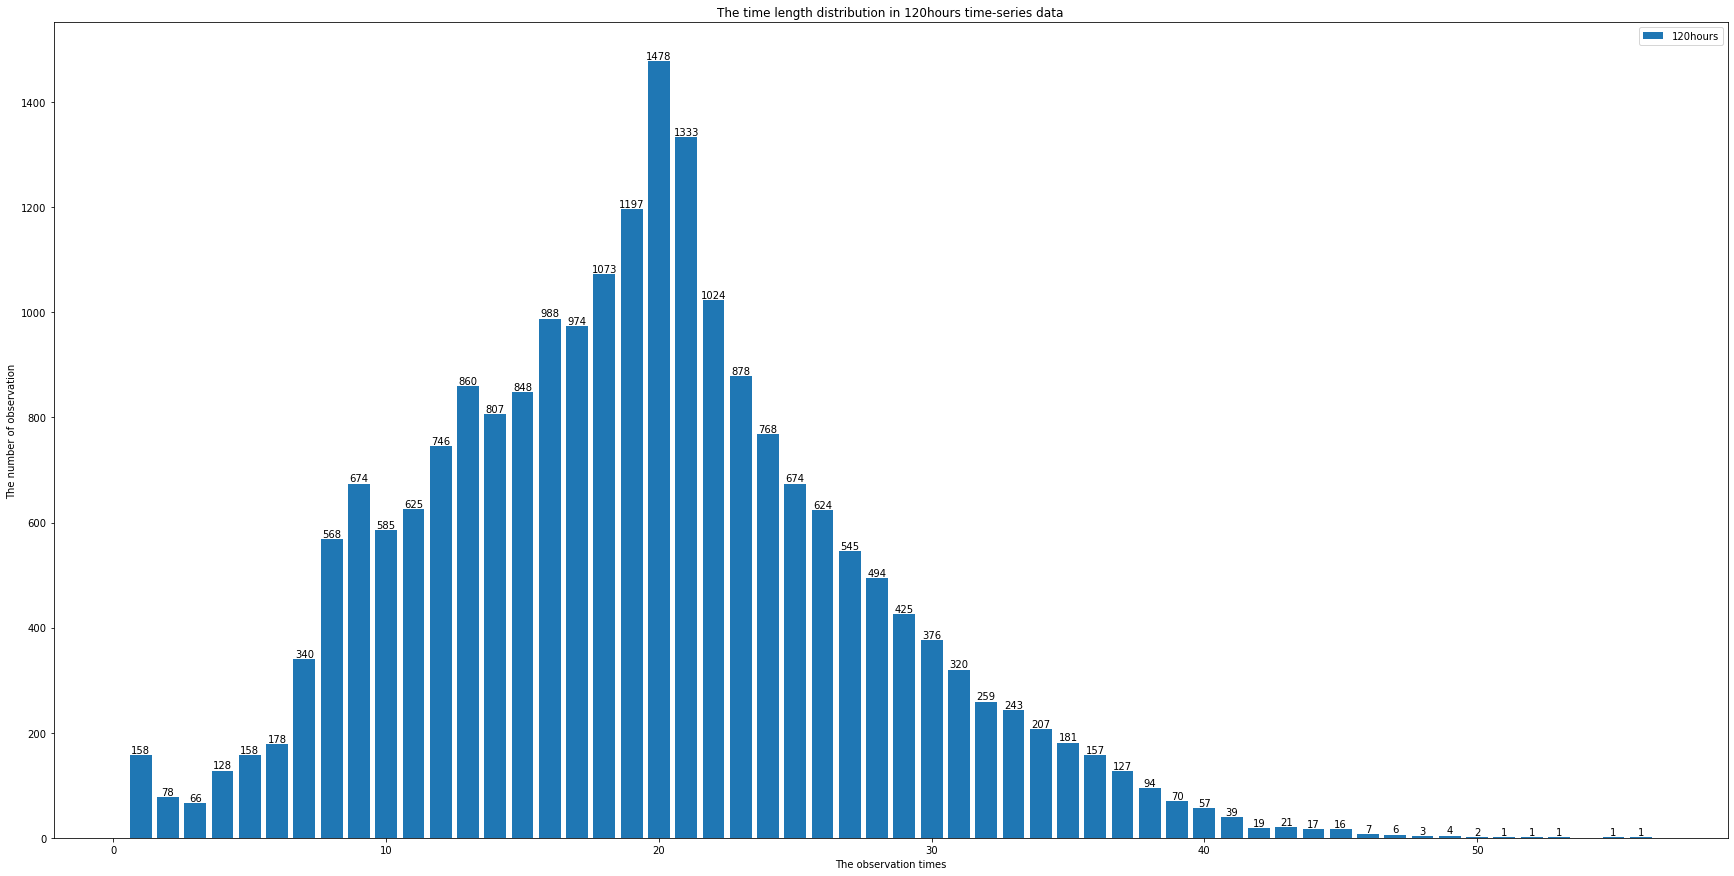

In [17]:
for key, value in len_dict.items():
    
    df = pd.DataFrame.from_dict(value, orient='index',columns=['counts'])
    df = df.reset_index().rename(columns = {'index':'length'})

    plt.figure(figsize=(30,15))
    p1 = plt.bar(df['length'], df['counts'], label='{}hours'.format(str(key).title()))
    for a, b in zip(df['length'], df['counts']):
        plt.text(a, b + 0.05, '%.0f' % b, ha='center', va='bottom', fontsize=10)
    plt.title('The time length distribution in {0}hours time-series data'.format(str(key).title()))
    plt.xlabel('The observation times')
    plt.ylabel('The number of observation')
    plt.legend()
    plt.savefig(os.path.join(OUTPUT_PATH, '{}hours'.format(key), 'Distribution_of_time_length({0}hours).png'.format(str(key))), bbox_inches='tight')
    plt.show()
    plt.close()

### 4- calculate the time span distribution of 48hours, 72hours, 96hours, 120hrs
- 1-after execute the script "2_Xhours_tsdata_preprocessing.ipynb"

In [2]:
T_LENGTH = [48, 72, 96, 120] # 48, 72, 96
OUTPUT_PATH = './output/phase_viii'
DATA_PATH = './data/phase_viii'
len_dict = {}
for t in T_LENGTH:
    DATA_PATH_SUBDIR = os.path.join(DATA_PATH, '{}hours'.format(t), 'processed', 'raw', 'data4hc_v20220401', 'data.npz')
    tsdata = np.load(DATA_PATH_SUBDIR, allow_pickle=True)

    time_span = []
    for i in range(tsdata['timestamp'].shape[0]):
        time_span.append(math.ceil(tsdata['timestamp'][i][-1]/(60*60)))
    result = Counter(time_span)
    len_dict[t] = result
np.save(os.path.join(OUTPUT_PATH, 'time_span.npy'), len_dict)

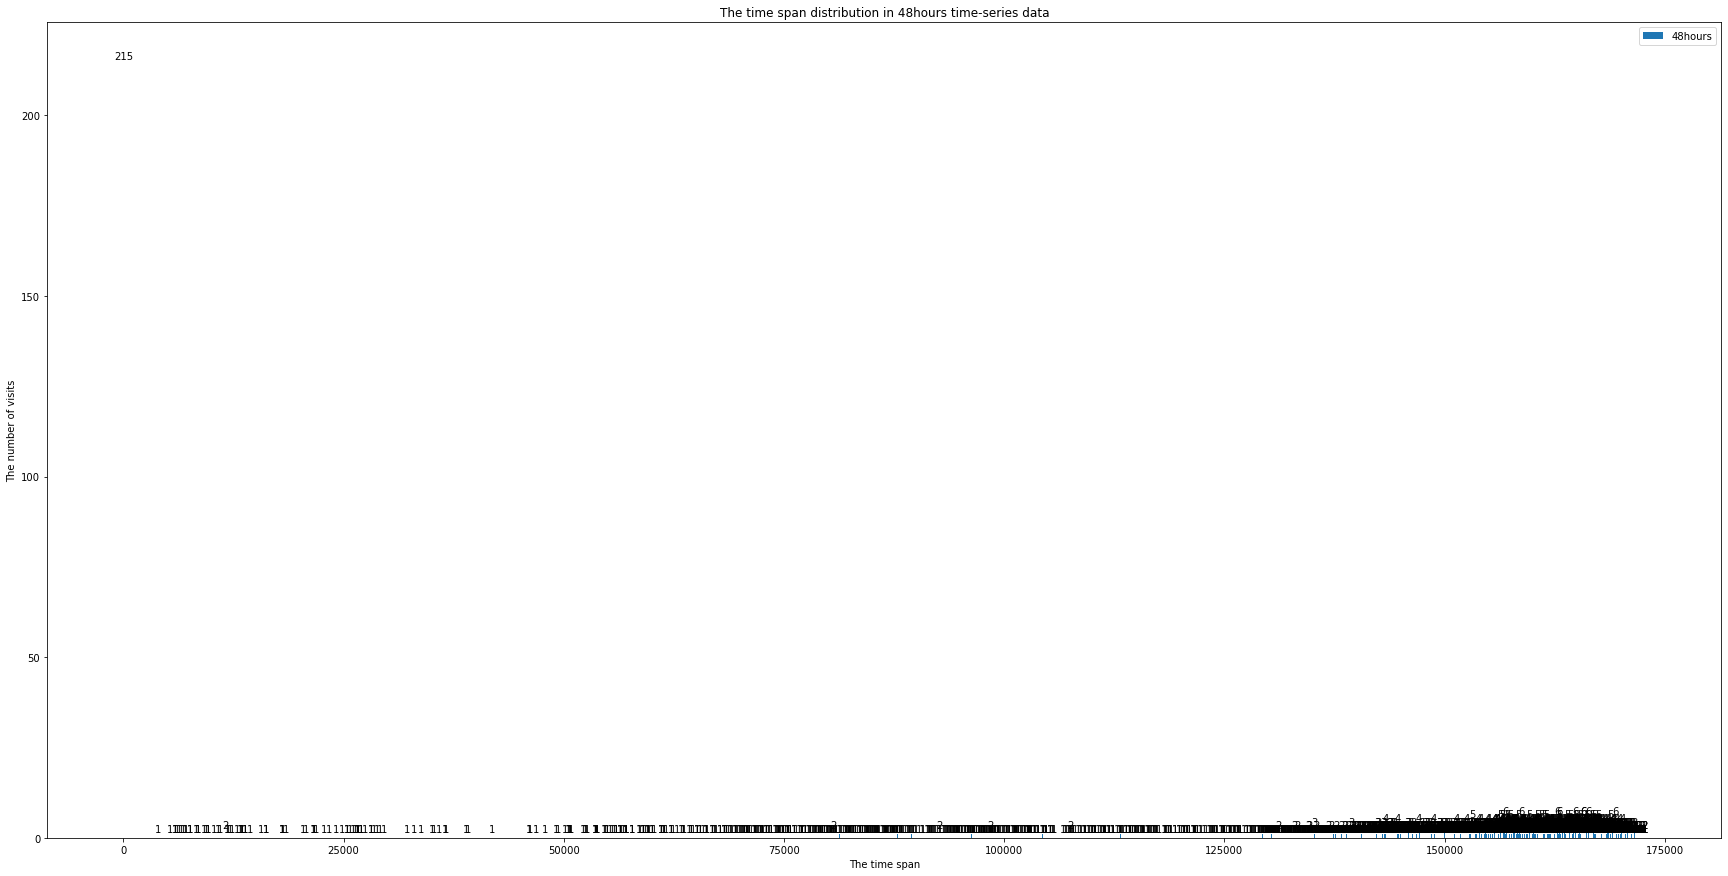

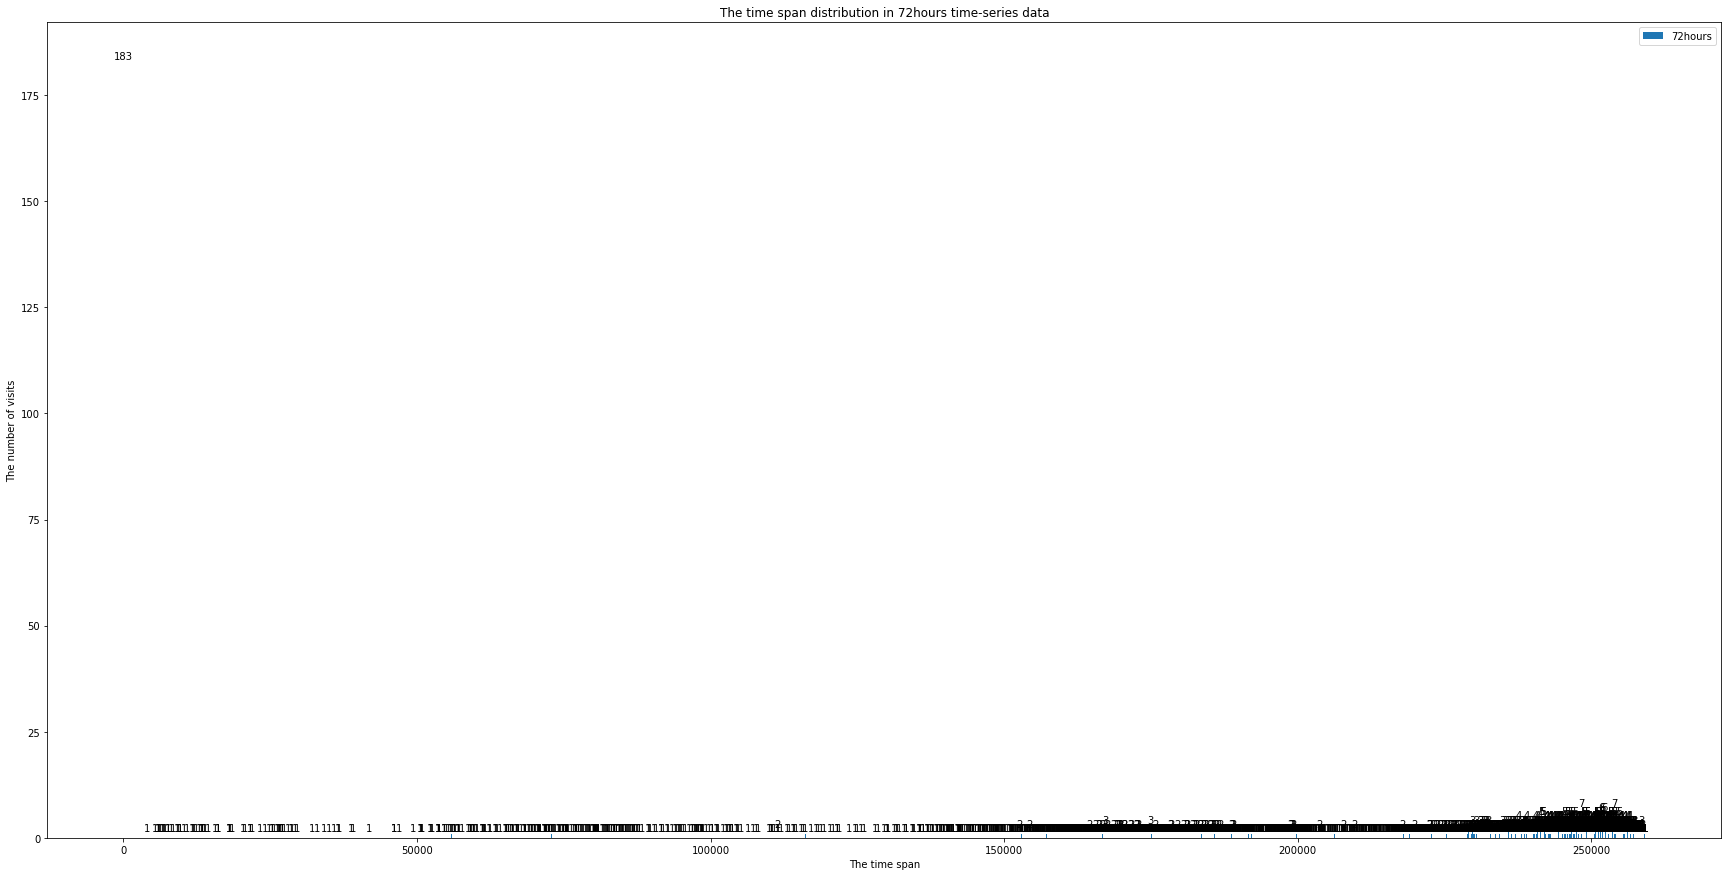

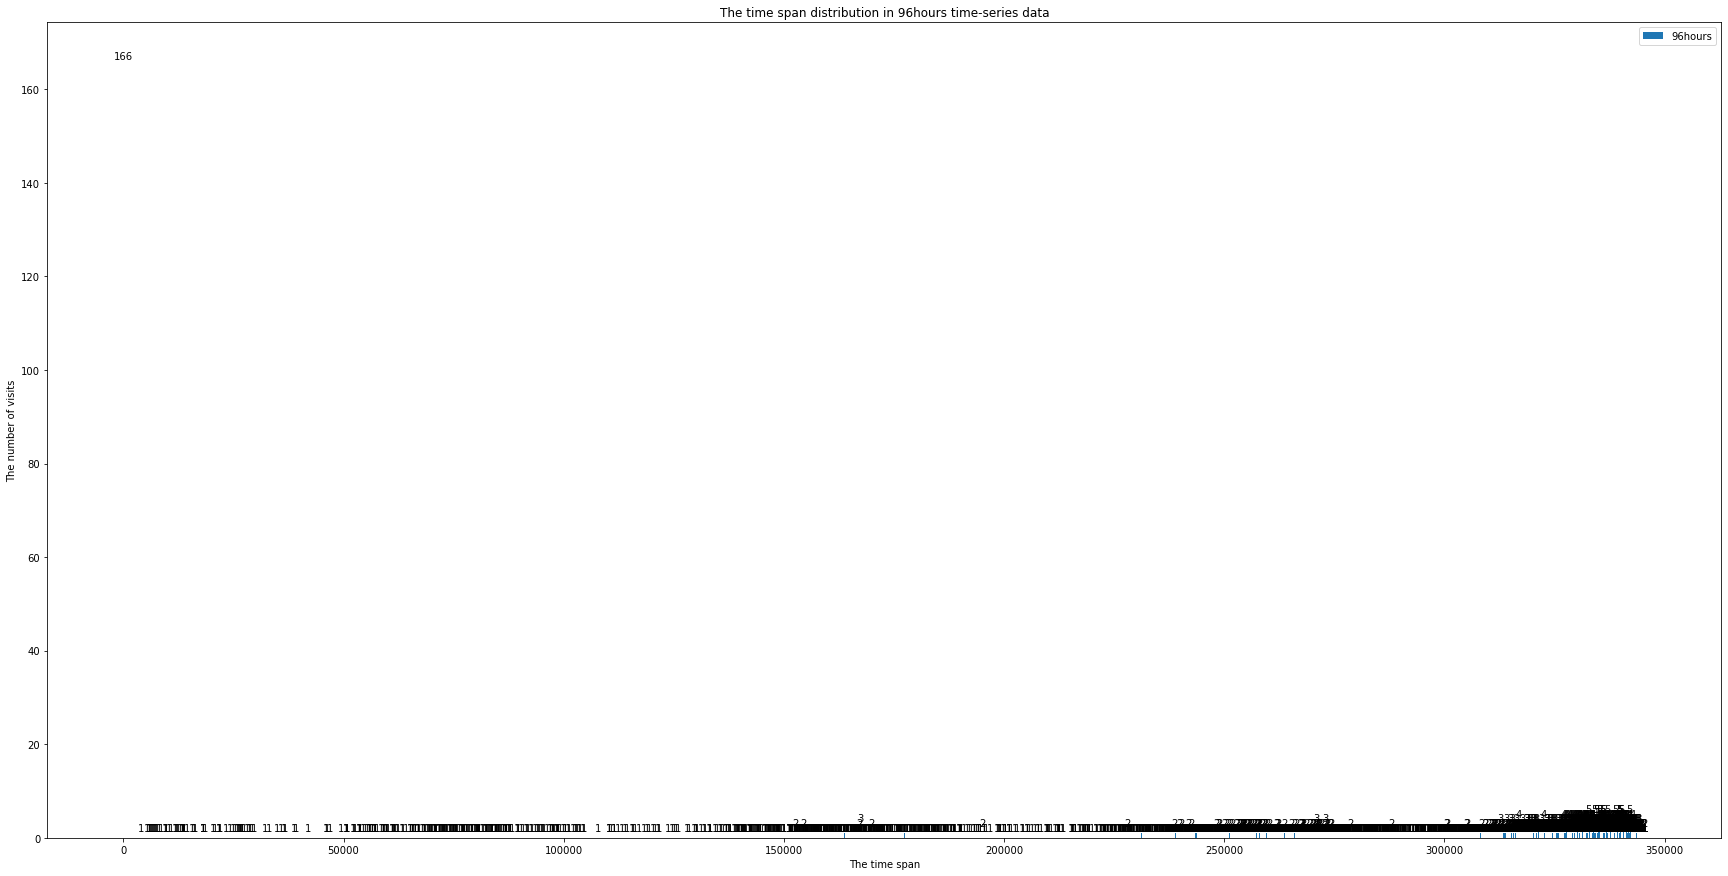

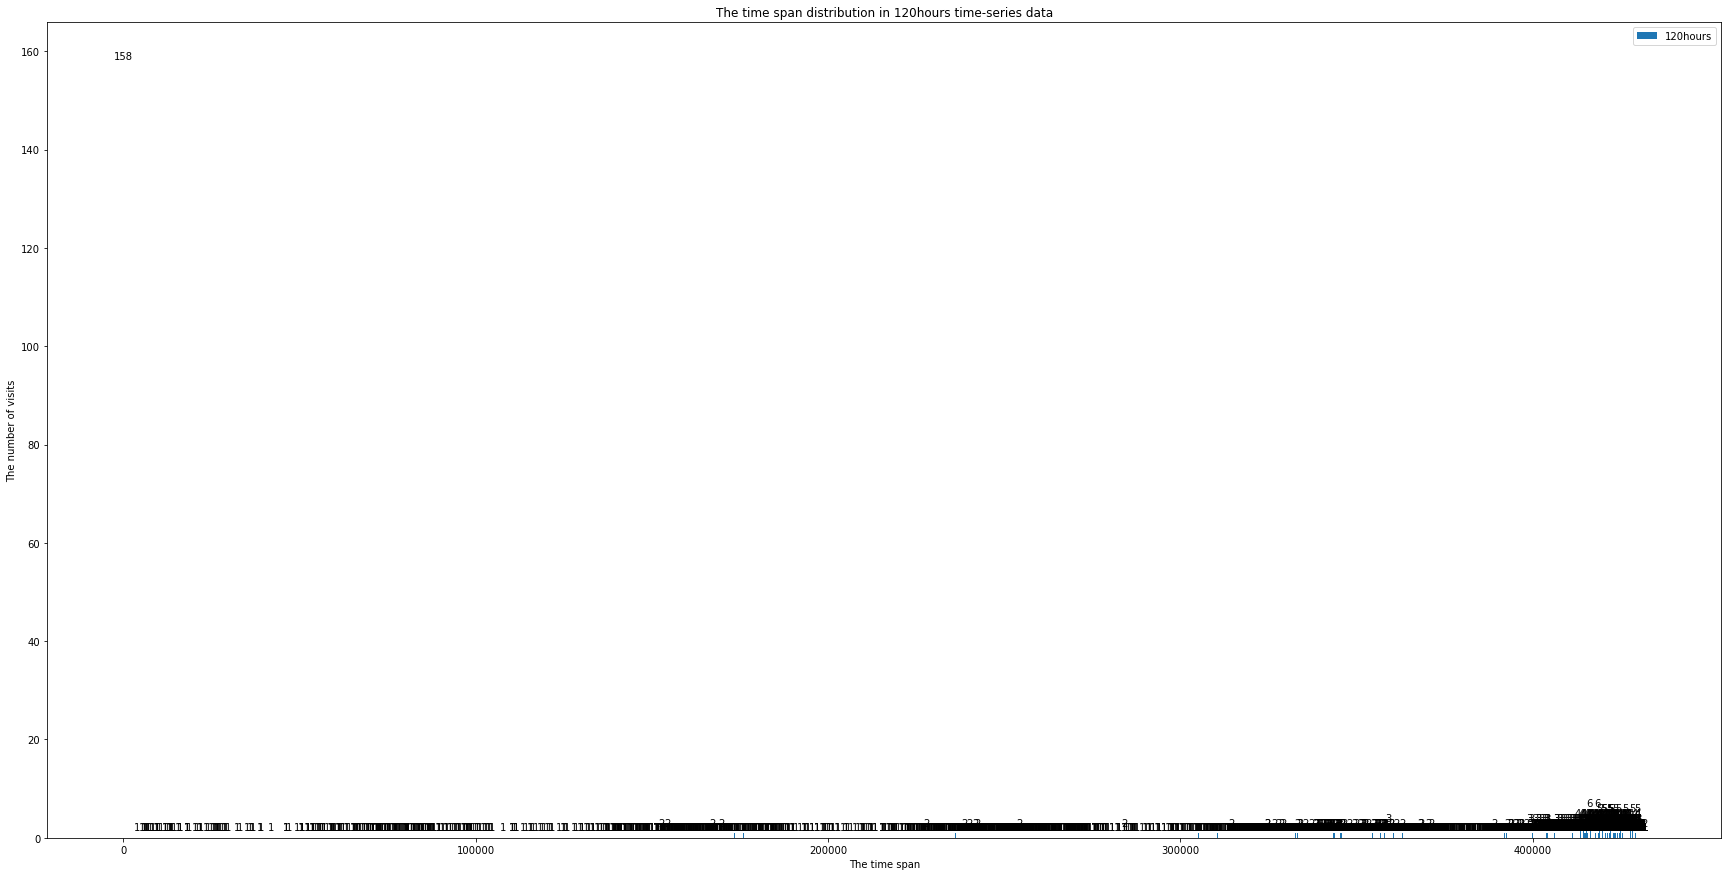

In [ ]:
for key, value in len_dict.items():
    
    df = pd.DataFrame.from_dict(value, orient='index',columns=['counts'])
    df = df.reset_index().rename(columns = {'index':'length'})

    plt.figure(figsize=(30,15))
    p1 = plt.bar(df['length'], df['counts'], label='{}hours'.format(str(key).title()))
    for a, b in zip(df['length'], df['counts']):
        plt.text(a, b + 0.05, '%.0f' % b, ha='center', va='bottom', fontsize=10)
    plt.title('The time span distribution in {0}hours time-series data'.format(str(key).title()))
    plt.xlabel('The time span')
    plt.ylabel('The number of visits')
    plt.legend()
    plt.savefig(os.path.join(OUTPUT_PATH, '{}hours'.format(key), 'Distribution_of_time_span({0}hours).png'.format(str(key))), bbox_inches='tight')
    plt.show()
    plt.close()